In [1]:
!pip install ipywidgets > /dev/null

In [ ]:
!pip install matplotlib > /dev/null
!pip install scikit-learn > /dev/null

In [ ]:
!pip install joblib >> /dev/null

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from numpy import mean

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score, cross_validate

from sklearn.metrics import precision_recall_curve, balanced_accuracy_score, precision_score, accuracy_score, recall_score, classification_report, PrecisionRecallDisplay, make_scorer, f1_score, average_precision_score
from sklearn.preprocessing import RobustScaler,OneHotEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import random
from sklearn.impute import SimpleImputer

import shap
from lime import lime_tabular
from category_encoders import CatBoostEncoder



In [3]:
df = pd.read_csv('transactions_480m.csv')

cols = ['Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC', 'Errors?', 'Is Fraud?']
df = df[cols]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Year            480000 non-null  int64  
 1   Month           480000 non-null  int64  
 2   Day             480000 non-null  int64  
 3   Time            480000 non-null  object 
 4   Amount          480000 non-null  float64
 5   Use Chip        480000 non-null  object 
 6   Merchant Name   480000 non-null  object 
 7   Merchant City   480000 non-null  object 
 8   Merchant State  426406 non-null  object 
 9   Zip             423296 non-null  float64
 10  MCC             480000 non-null  int64  
 11  Errors?         7683 non-null    object 
 12  Is Fraud?       480000 non-null  object 
dtypes: float64(2), int64(4), object(7)
memory usage: 47.6+ MB


In [5]:
df['Class']  = df['Is Fraud?'].astype('category')
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
df.drop(['Is Fraud?'], axis=1, inplace=True)

df['Time'] = pd.to_datetime(df['Time']).astype(int)/ 10**9

df['UC'] = df['Use Chip']
df['MN'] = df['Merchant Name']
df['MC'] = df['Merchant City']
df['MS'] = df['Merchant State']
df['errors'] = df['Errors?']
df.drop(['Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Errors?'], axis=1, inplace=True)

df.head()

,Year,Month,Day,Time,Amount,Zip,MCC,Class,UC,MN,MC,MS,errors
0,2009,6,10,1.682722e+09,26.42,92335.0,5411,0,Swipe Transaction,"-7,27612092139916E+017",Fontana,CA,NaN
1,2018,4,1,1.682702e+09,33.26,80301.0,5300,0,Chip Transaction,"3,76178035798556E+018",Boulder,CO,NaN
2,2000,8,30,1.682712e+09,2.15,95822.0,5912,0,Swipe Transaction,"-5,4679223516925E+018",Sacramento,CA,NaN
3,2008,11,8,1.682667e+09,29.16,77406.0,5411,0,Swipe Transaction,"9,70327976898217E+016",Richmond,TX,"Bad PIN,"
4,2009,12,13,1.682674e+09,29.69,NaN,4784,0,Online Transaction,"-2,08849241165016E+018",ONLINE,NaN,NaN


In [4]:
df = pd.read_csv('transactions_480m.csv')

df['Class']      = df['Is Fraud?'].astype('category')
df['use_chip']   = df['Use Chip'].astype('category')
df['errors']     = df['Errors?'].astype('category')
df['merchant_name']     = df['Merchant Name'].astype('category')
df['merchant_city']     = df['Merchant City'].astype('category')
df['merchant_state']    = df['Merchant State'].astype('category')

df['Time']       = pd.to_datetime(df['Time']).astype(int)/ 10**9

cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

classe = df['Class']
chip   = df['use_chip']
errors = df['errors']
merchant_name  = df['merchant_name']
merchant_city  = df['merchant_city']
merchant_state = df['merchant_state'] 

df.convert_dtypes().dtypes 

df.drop(['use_chip','errors', 'merchant_name', 'merchant_city', 'merchant_state', 'Is Fraud?', 'Class', 'Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Errors?'], axis=1, inplace=True)
df.insert(0, 'Class', classe)
df.insert(1, 'use_chip', chip)
df.insert(2, 'errors', errors)
df.insert(3, 'merchant_name', merchant_name)
df.insert(4, 'merchant_city', merchant_city)
df.insert(5, 'merchant_state', merchant_state)

df.dtypes
df.head()

,Class,use_chip,errors,merchant_name,merchant_city,merchant_state,User,Card,Year,Month,Day,Time,Amount,Zip,MCC
0,0,2,-1,9171,2378,20,860,1,2009,6,10,1.680562e+09,26.42,92335.0,5411
1,0,0,-1,16176,709,21,1897,3,2018,4,1,1.680542e+09,33.26,80301.0,5300
2,0,2,-1,6505,6171,20,1627,1,2000,8,30,1.680552e+09,2.15,95822.0,5912
3,0,2,9,24384,5954,141,453,0,2008,11,8,1.680507e+09,29.16,77406.0,5411
4,0,1,-1,1543,0,-1,1339,1,2009,12,13,1.680514e+09,29.69,NaN,4784


In [6]:
fraud_percent      = df['Class'].value_counts()[0] / len(df) * 100
not_fraud_percent = df['Class'].value_counts()[1] / len(df) * 100

print("Porcentagem de transações fraudulentas %.2f"%fraud_percent)
print("Porcentagem de transações não fraudulentas %.2f"%not_fraud_percent)

Porcentagem de transações fraudulentas 99.88
Porcentagem de transações não fraudulentas 0.12


In [7]:
X = df.drop('Class', axis=1)
y = df['Class']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Year    480000 non-null  int64  
 1   Month   480000 non-null  int64  
 2   Day     480000 non-null  int64  
 3   Time    480000 non-null  float64
 4   Amount  480000 non-null  float64
 5   Zip     423296 non-null  float64
 6   MCC     480000 non-null  int64  
 7   UC      480000 non-null  object 
 8   MN      480000 non-null  object 
 9   MC      480000 non-null  object 
 10  MS      426406 non-null  object 
 11  errors  7683 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 43.9+ MB


In [9]:
default_pos_color = "#008bfb"

In [8]:
data_dict = {
    'logistic_regression_values': [],
    'logistic_regression_lime': [], 
    'logistic_regression_shap': [],
    'random_forest_lime': [],
    'random_forest_shap': [],
    'svm_lime': [],
    'svm_shap': [],
    'mlp_classifier_lime': [],
    'mlp_classifier_shap': [],
    'decision_tree_lime': [],
    'decision_tree_shap': []
}

def save_model_data(model, data, method):
    if isinstance(model, LogisticRegression):
        if method == 'lime': 
            data_dict['logistic_regression_lime'].append(data)
        else:
            if method == 'shap':
                data_dict['logistic_regression_shap'].append(data)
            else:
                data_dict['logistic_regression_values'].append(data)
    elif isinstance(model, RandomForestClassifier):
        if method == 'lime': 
            data_dict['random_forest_lime'].append(data)
        else:
            data_dict['random_forest_shap'].append(data)
    elif isinstance(model, LinearSVC):
        if method == 'lime': 
            data_dict['svm_lime'].append(data)
        else:
            data_dict['svm_shap'].append(data)
    elif isinstance(model, MLPClassifier):
        if method == 'lime': 
            data_dict['mlp_classifier_lime'].append(data)
        else:
            data_dict['mlp_classifier_shap'].append(data)
    elif isinstance(model, DecisionTreeClassifier):
        if method == 'lime': 
            data_dict['decision_tree_lime'].append(data)
        else:
            data_dict['decision_tree_shap'].append(data)
    else:
        print("Unrecognized model type")

In [10]:
def plot_results_logistic_regression_to_file(training_results):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        avg_model_coeficients = np.mean(abs(model.coef_), axis=0)
        top_indices = np.argsort(avg_model_coeficients)[::-1][:10]

        bars = axes[i].barh(np.arange(10), np.flip(avg_model_coeficients[top_indices]), align='center', color=default_pos_color)

        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(avg_model_coeficients[top_indices])[j]), \
                    ha='left', va='center', color=default_pos_color)
        
        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(fraud_sample.keys()[top_indices]))
        
        data = np.flip(fraud_sample.keys()[top_indices])
        save_model_data(model, data, 'reg')
    
    plt.suptitle("Regressão logística (Pesos do modelo)")
    plt.savefig("syntetic_img/logistic_regression_feature_importance_plot.pdf", format="pdf")
    plt.savefig("syntetic_img/logistic_regression_feature_importance_plot.png")
    axes[0].set_ylabel('Nome do preditor')
    
def plot_lime_results_to_file_for_svm(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        explainer = training_results['lime_explainers'][i]
        
        explanation = explainer.explain_instance(
            data_row=fraud_sample,
            predict_fn=model._predict_proba_lr
        )
        
        feature_names   = []
        feature_weights = []
        
        for index, tup in enumerate(explanation.as_map()[1]):
            feature_names.append(fraud_sample.keys()[tup[0]])
            feature_weights.append(abs(tup[1]))
        
        features_weights = np.array(np.abs(feature_weights)).mean(axis=0)
        top_indices = np.argsort(features_weights)[::-1][:10]
          
        bars = axes[i].barh(np.arange(10), np.flip(feature_weights), align='center', color=default_pos_color)
        
        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(feature_weights)[j]), \
                    ha='left', va='center', color=default_pos_color)

        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(feature_names))
        
        save_model_data(model, np.flip(feature_names), 'lime')
    
    axes[0].set_ylabel('Nome do preditor')
    plt.suptitle(plot_title)
    plt.savefig(file_name)
    
def plot_lime_results_to_file(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        model = training_results['models'][i]
        explainer = training_results['lime_explainers'][i]
        
        explanation = explainer.explain_instance(
            data_row=fraud_sample,
            predict_fn=model.predict_proba
        )
        
        feature_names   = []
        feature_weights = []
        
        
        for index, tup in enumerate(explanation.as_map()[1]):
            feature_names.append(fraud_sample.keys()[tup[0]])
            feature_weights.append(abs(tup[1]))
        
        features_weights = np.array(np.abs(feature_weights)).mean(axis=0)
        top_indices = np.argsort(features_weights)[::-1][:10]
        
        
        bars = axes[i].barh(np.arange(10), np.flip(feature_weights), align='center', color=default_pos_color)
        
        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(feature_weights)[j]), \
                    ha='left', va='center', color=default_pos_color)

        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(feature_names))
        
        save_model_data(model, np.flip(feature_names), 'lime')
    
    axes[0].set_ylabel('Nome do preditor')
    plt.suptitle(plot_title)
    plt.savefig(file_name)

    
def plot_shap_results_to_file(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.2)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        explainer   = training_results['shap_explainers'][i]
        shap_values = explainer(fraud_sample.values.reshape(1,-1)).values
        
        if (shap_values.ndim == 3):
            fraud_shap_values = shap_values[0][:, 1]
            fraud_shap_values_reset = pd.Series(fraud_shap_values, index=pd.Index(fraud_sample.keys()))
            fraud_shap_values_abs = np.abs(fraud_shap_values_reset.values)
            fraud_shap_values_abs = fraud_shap_values_abs.reshape(1, -1)
            mean_shap_values = fraud_shap_values_abs.mean(axis=0)
        else:
            mean_shap_values = np.abs(shap_values).mean(axis=0)

        top_indices = np.argsort(mean_shap_values)[::-1][:10]
        
        bars = axes[i].barh(np.arange(10), np.flip(mean_shap_values[top_indices]), align='center', color=default_pos_color)

        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(mean_shap_values[top_indices])[j]), \
                    ha='left', va='center', color=default_pos_color)
        
        #axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(    fraud_sample.keys()[top_indices]   ))
        
        data = np.flip(fraud_sample.keys()[top_indices])
        save_model_data(model, data, 'shap')
    
    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')

In [11]:
def normal_train (model_algorithm, X, y, shap_type='', pred=False):

    shap_explainers    = []
    lime_explainers    = []
    models             = []
    samples            = []
    
    precision_scores   = []
    f1_scores          = []
    balanced_acuracies = []
    sensitivity_scores = []
    specificity_scores = []
    auprc_scores       = []
    
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    
    for train_index, test_index in cv.split(X, y):
        
        if model_algorithm == 0:
            model = LogisticRegression(max_iter=2000, solver='newton-cholesky', random_state=1)
        elif model_algorithm == 1:
            model = DecisionTreeClassifier(random_state=1)
        elif model_algorithm == 2:
            model = RandomForestClassifier(max_depth=2, random_state=1)
        elif model_algorithm == 3:
            model = LinearSVC(max_iter=2000, dual=False, random_state=1)
        else:
            model =  MLPClassifier(random_state=1)
            
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train = X_train.copy()
        X_test = X_test.copy()
        
        numeric_cols = ['Year', 'Month', 'Day', 'Amount', 'MCC']
        numeric_imputer = SimpleImputer(strategy='median')
        X_train.loc[:, numeric_cols] = numeric_imputer.fit_transform(X_train[numeric_cols])
        X_test.loc[:, numeric_cols] = numeric_imputer.transform(X_test[numeric_cols])

        categorical_cols = ['UC', 'MN', 'MC', 'MS', 'Zip', 'errors']
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        X_train.loc[:, categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])
        X_test.loc[:, categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])

        encoder = CatBoostEncoder(random_state=1)
        encoded_cols = encoder.fit_transform(X_train.loc[:, categorical_cols], y_train)
        X_train = pd.concat([X_train.drop(columns=categorical_cols), encoded_cols], axis=1)
        encoded_cols = encoder.transform(X_test.loc[:, categorical_cols], y_test)
        X_test = pd.concat([X_test.drop(columns=categorical_cols), encoded_cols], axis=1)
        
        scaler = RobustScaler()
        X_train.loc[:, ['Time']] = scaler.fit_transform(X_train[['Time']])
        X_test.loc[:, ['Time']] = scaler.transform(X_test[['Time']])
             
        oversample = SMOTE(random_state=1)
        X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

        positive_samples_index = np.where(y_train == 1)[0]
        random_positive_sample_index = np.random.choice(positive_samples_index)
        random_positive_sample = X_train.iloc[random_positive_sample_index]
        samples.append(random_positive_sample)
        
        
        model.fit(X_train_smote, y_train_smote)
        models.append(model)
        

        #SHAP Stuff
        shapexplainer = shap.Explainer(model.predict, X_train_smote, seed=1)   
        shap_explainers.append(shapexplainer)

        #LIME Stuff
        lime_explainer = lime_tabular.LimeTabularExplainer(
            training_data=np.array(X_train_smote),
            feature_names=X_train_smote.columns,
            class_names=['legítima', 'fraude'],
            mode='classification',
            random_state=1
        )
        
        lime_explainers.append(lime_explainer)
        
        y_pred = model.predict(X_test)
        
        balanced_acuracies.append(balanced_accuracy_score(y_test, y_pred))
        sensitivity_scores.append(recall_score(y_test, y_pred))
        specificity_scores.append(recall_score(y_test, y_pred, pos_label=0))
        precision_scores.append(precision_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        auprc_scores.append(average_precision_score(y_test, y_pred))
     
    
    return {
        'shap_explainers'    : shap_explainers,
        'lime_explainers'    : lime_explainers,
        'models'             : models,
        'samples'            : samples,
        'sensitivity_scores' : sensitivity_scores,
        'balanced_acuracies' : balanced_acuracies,
        'specificity_scores' : specificity_scores,
        'precision_scores'   : precision_scores,
        'f1_scores'          : f1_scores,
        'auprc_scores'       : auprc_scores
    }


In [7]:
def plot_results_logistic_regression_to_file(training_results):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.5)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        avg_model_coeficients = np.mean(abs(model.coef_), axis=0)
        top_indices = np.argsort(avg_model_coeficients)[::-1][:10]
        avg_model_coeficients = np.flip(avg_model_coeficients[top_indices])

        bars = axes[i].barh(np.arange(10), avg_model_coeficients, align='center', color=default_pos_color)

        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, \
                    '{:.2f}'.format(avg_model_coeficients[j]), \
                    ha='left', va='center', color=default_pos_color)
        
        axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(fraud_sample.keys()[top_indices]))
    
    plt.suptitle("Regressão Logística (Pesos do modelo)")
    plt.savefig("syntetic_img/logistic_regression_feature_importance_plot.png")
    axes[0].set_ylabel('Nome do preditor')

In [8]:
def plot_lime_results_to_file_for_svm(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.5)

    for i in range (0, 5):
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        explainer = training_results['lime_explainers'][i]
        
        explanation = explainer.explain_instance(
            data_row=fraud_sample,
            predict_fn=model._predict_proba_lr
        )
        
        feature_names   = []
        feature_weights = []
        
        
        for index, tup in enumerate(explanation.as_map()[1]):
            feature_names.append(fraud_sample.keys()[tup[0]])
            feature_weights.append(abs(tup[1]))
        
        features_weights = np.array(np.abs(feature_weights)).mean(axis=0)
        top_indices = np.argsort(features_weights)[::-1][:10]
        
        
        bars = axes[i].barh(np.arange(10), np.flip(feature_weights), align='center', color=default_pos_color)
        
        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(feature_weights)[j]), \
                    ha='left', va='center', color=default_pos_color)

        axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(feature_names))
    
    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')

In [9]:
def plot_lime_results_to_file(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.5)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        explainer = training_results['lime_explainers'][i]
        
        explanation = explainer.explain_instance(
            data_row=fraud_sample,
            predict_fn=model.predict_proba
        )
        
        feature_names   = []
        feature_weights = []
        
        
        for index, tup in enumerate(explanation.as_map()[1]):
            feature_names.append(fraud_sample.keys()[tup[0]])
            feature_weights.append(abs(tup[1]))
        
        features_weights = np.array(np.abs(feature_weights)).mean(axis=0)
        top_indices = np.argsort(features_weights)[::-1][:10]
        
        
        bars = axes[i].barh(np.arange(10), np.flip(feature_weights), align='center', color=default_pos_color)
        
        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.3f}'.format(np.flip(feature_weights)[j]), \
                    ha='left', va='center', color=default_pos_color)

        axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(feature_names))
    
    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')

In [1]:
def plot_shap_results_to_file(training_results, plot_title, file_name):

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3), sharey=False)
    fig.tight_layout(pad=3.5)

    for i in range (0, 5):
        
        fraud_sample = training_results['samples'][i]
        
        model = training_results['models'][i]
        explainer   = cross_log['shap_explainers'][i]
        shap_values = explainer(fraud_sample.values.reshape(1,-1))
        
        
        mean_shap_values = np.array(np.abs(shap_values.values)).mean(axis=0)
        top_indices = np.argsort(mean_shap_values)[::-1][:10]

        bars = axes[i].barh(np.arange(10), np.flip(mean_shap_values[top_indices]), align='center', color=default_pos_color)

        for j, bar in enumerate(bars):
            axes[i].text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2., \
                    '{:.2f}'.format(np.flip(mean_shap_values[top_indices])[j]), \
                    ha='left', va='center', color=default_pos_color)
        
        axes[i].set_xlabel('Fold {}'.format(i+1))
        axes[i].spines["right"].set_visible(False)
        axes[i].spines["top"].set_visible(False)
        axes[i].set_yticks(np.arange(10))
        axes[i].set_yticklabels(np.flip(fraud_sample.keys()[top_indices]))
    
    plt.suptitle(plot_title)
    plt.savefig(file_name)
    axes[0].set_ylabel('Nome do preditor')

### Training the models

In [30]:
cross_decision_tree = normal_train(1, X, y, shap_type='Tree')

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

In [31]:
print("Métricas árvore de decisão: \n")

print("Sensibilidade: %f\n"%np.mean(cross_decision_tree['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(cross_decision_tree['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(cross_decision_tree['specificity_scores']))
print("Precisão: %f\n"%np.mean(cross_decision_tree['precision_scores']))
print("F1: %f\n"%np.mean(cross_decision_tree['f1_scores']))
print("AUPRC: %f\n"%np.mean(cross_decision_tree['auprc_scores']))

Métricas árvore de decisão: 

Sensibilidade: 0.386401

Acurácia balanceada: 0.682992

Especificidade: 0.979583

Precisão: 0.026125

F1: 0.048533

AUPRC: 0.011497



In [32]:
cross_random_fres   = normal_train(2, X, y, shap_type='Tree')

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

In [33]:
print("Métricas florestas aleatórias: \n")

print("Sensibilidade: %f\n"%np.mean(cross_random_fres['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(cross_random_fres['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(cross_random_fres['specificity_scores']))
print("Precisão: %f\n"%np.mean(cross_random_fres['precision_scores']))
print("F1: %f\n"%np.mean(cross_random_fres['f1_scores']))
print("AUPRC: %f\n"%np.mean(cross_random_fres['auprc_scores']))

Métricas florestas aleatórias: 

Sensibilidade: 0.841008

Acurácia balanceada: 0.858104

Especificidade: 0.875199

Precisão: 0.008375

F1: 0.016583

AUPRC: 0.007233



In [34]:
cross_log           = normal_train(0, X, y, pred=True)

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

In [35]:
print("Métricas regressão logística: \n")

print("Sensibilidade: %f\n"%np.mean(cross_log['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(cross_log['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(cross_log['specificity_scores']))
print("Precisão: %f\n"%np.mean(cross_log['precision_scores']))
print("F1: %f\n"%np.mean(cross_log['f1_scores']))
print("AUPRC: %f\n"%np.mean(cross_log['auprc_scores']))

Métricas regressão logística: 

Sensibilidade: 0.800868

Acurácia balanceada: 0.840552

Especificidade: 0.880236

Precisão: 0.008280

F1: 0.016391

AUPRC: 0.006879



In [36]:
cross_svm            = normal_train(3, X, y, pred=True)

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

In [37]:
print("Métricas SVM: \n")

print("Sensibilidade: %f\n"%np.mean(cross_svm['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(cross_svm['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(cross_svm['specificity_scores']))
print("Precisão: %f\n"%np.mean(cross_svm['precision_scores']))
print("F1: %f\n"%np.mean(cross_svm['f1_scores']))
print("AUPRC: %f\n"%np.mean(cross_svm['auprc_scores']))

Métricas SVM: 

Sensibilidade: 0.862927

Acurácia balanceada: 0.761640

Especificidade: 0.660352

Precisão: 0.003159

F1: 0.006295

AUPRC: 0.002897



In [1]:
cross_ann           = normal_train(4, X, y, pred=True)

NameError: name 'normal_train' is not defined

In [12]:
print("Métricas ANN: \n")

print("Sensibilidade: %f\n"%np.mean(cross_ann['sensitivity_scores']))
print("Acurácia balanceada: %f\n"%np.mean(cross_ann['balanced_acuracies']))
print("Especificidade: %f\n"%np.mean(cross_ann['specificity_scores']))
print("Precisão: %f\n"%np.mean(cross_ann['precision_scores']))
print("F1: %f\n"%np.mean(cross_ann['f1_scores']))
print("AUPRC: %f\n"%np.mean(cross_ann['auprc_scores']))

Métricas ANN: 

Sensibilidade: 0.672661

Acurácia balanceada: 0.796877

Especificidade: 0.921094

Precisão: 0.016187

F1: 0.031129

AUPRC: 0.010064



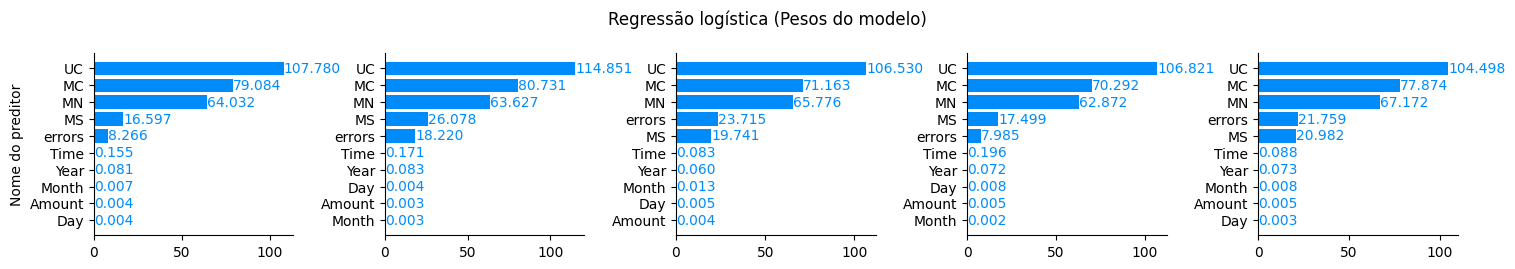

In [53]:
plot_results_logistic_regression_to_file(cross_log)

## SHAP plots

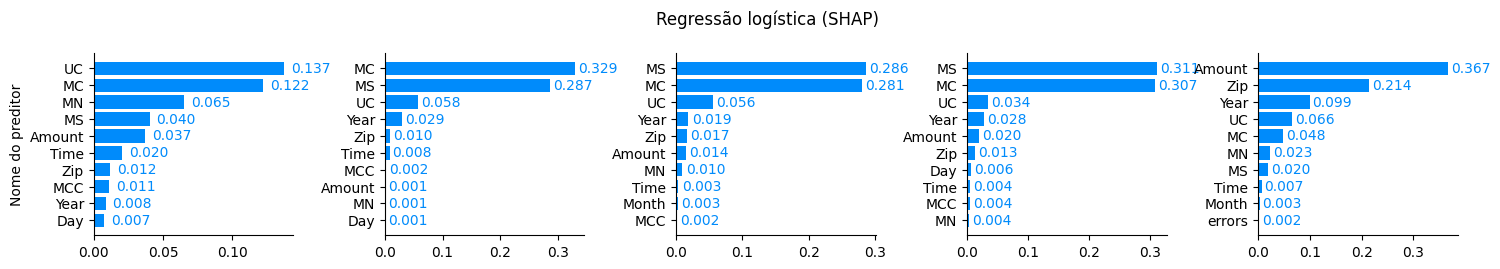

In [54]:
plot_shap_results_to_file(cross_log, "Regressão logística (SHAP)", "syntetic_img/logistic_regression_feature_importance_plot(shap).pdf")

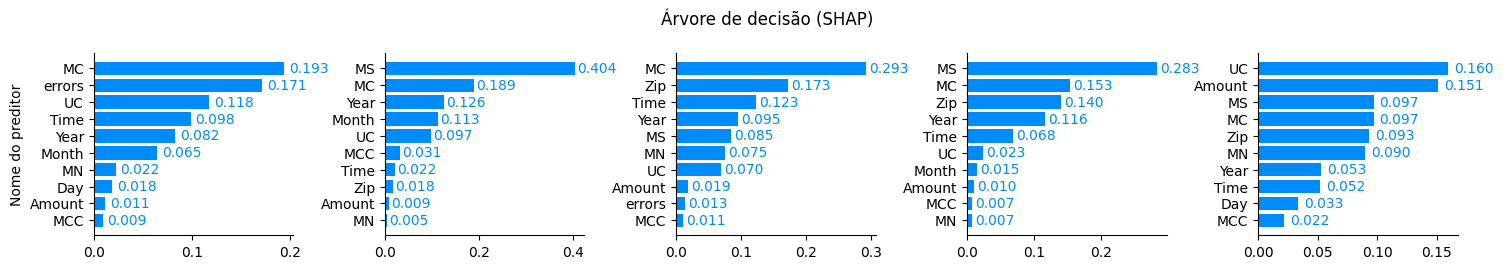

In [55]:
plot_shap_results_to_file(cross_decision_tree, "Árvore de decisão (SHAP)", "syntetic_img/decision_tree_feature_importance_plot(shap).pdf")

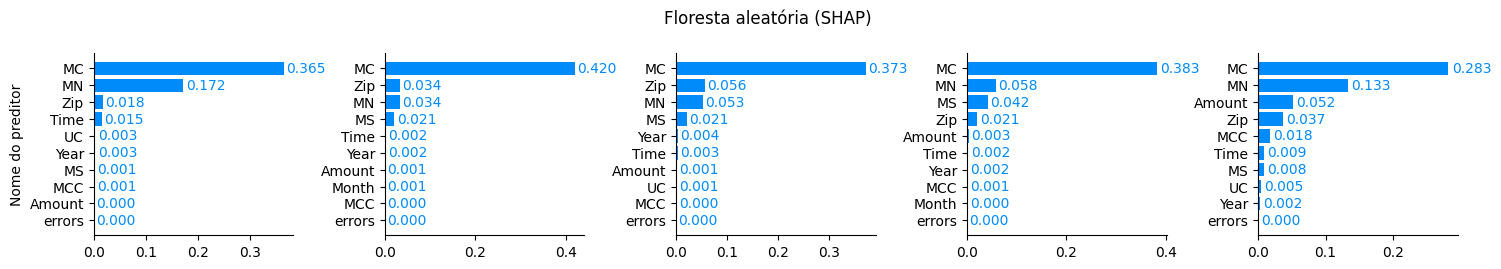

In [56]:
plot_shap_results_to_file(cross_random_fres, "Floresta aleatória (SHAP)", "syntetic_img/random_forest_feature_importance_plot(shap).pdf")

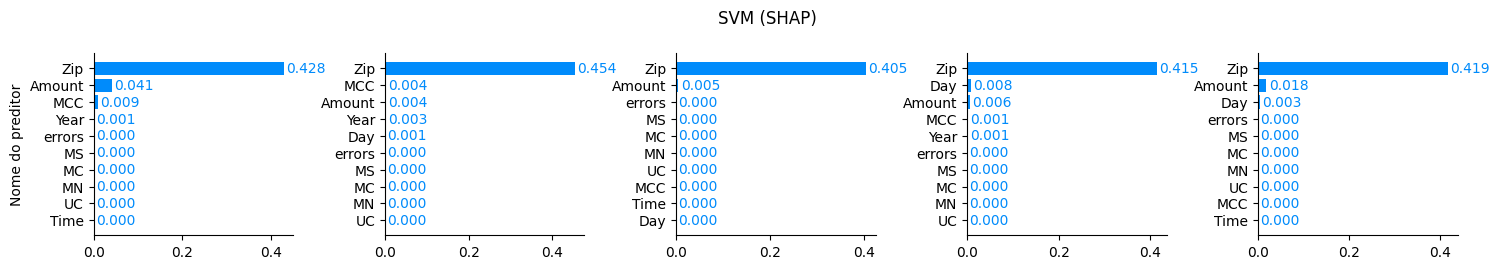

In [57]:
plot_shap_results_to_file(cross_svm, "SVM (SHAP)", "syntetic_img/svm_feature_importance_plot(shap).pdf")

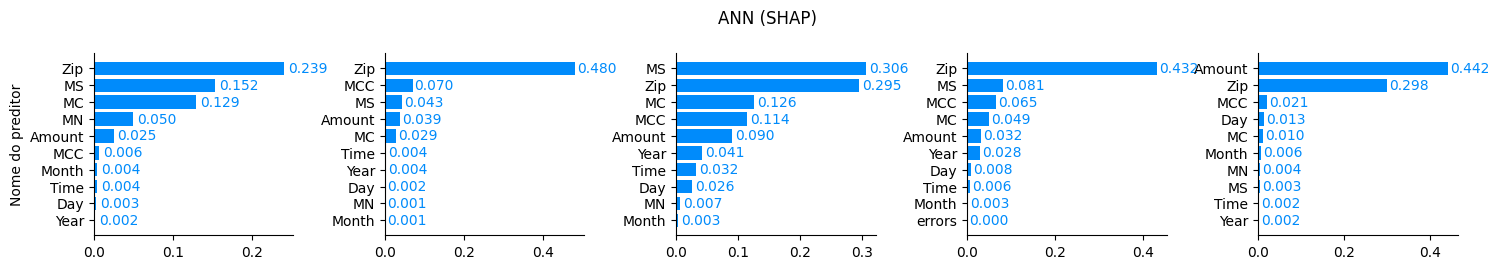

In [58]:
plot_shap_results_to_file(cross_ann, "ANN (SHAP)", "syntetic_img/ann_feature_importance_plot(shap).pdf")

## LIME plots

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


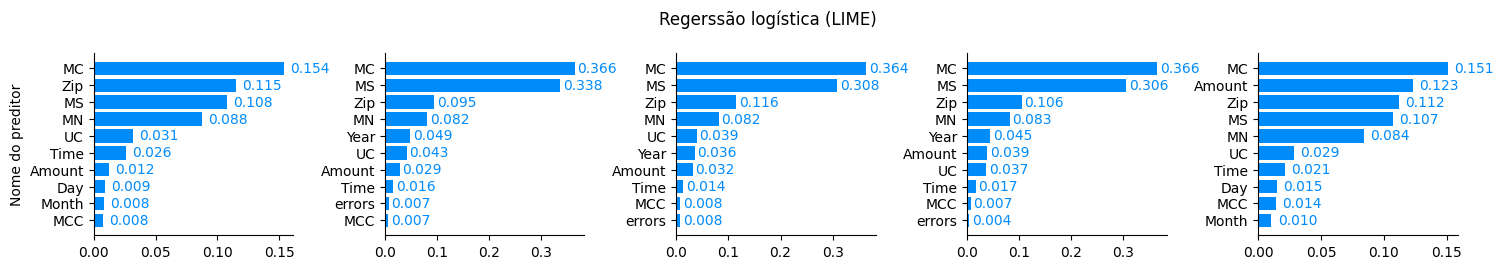

In [59]:
plot_lime_results_to_file(cross_log, "Regerssão logística (LIME)", "syntetic_img/logistic_regression_feature_importance_plot(lime).pdf")

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


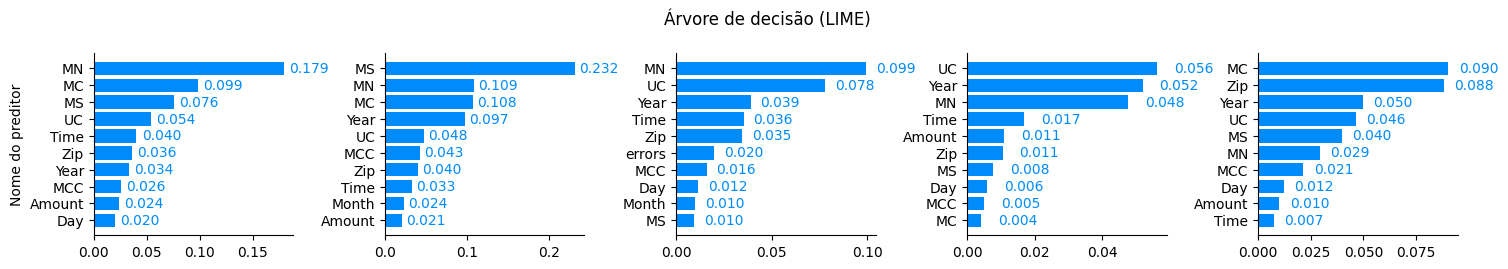

In [60]:
plot_lime_results_to_file(cross_decision_tree, "Árvore de decisão (LIME)", "syntetic_img/decision_tree_feature_importance_plot(lime).pdf")

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


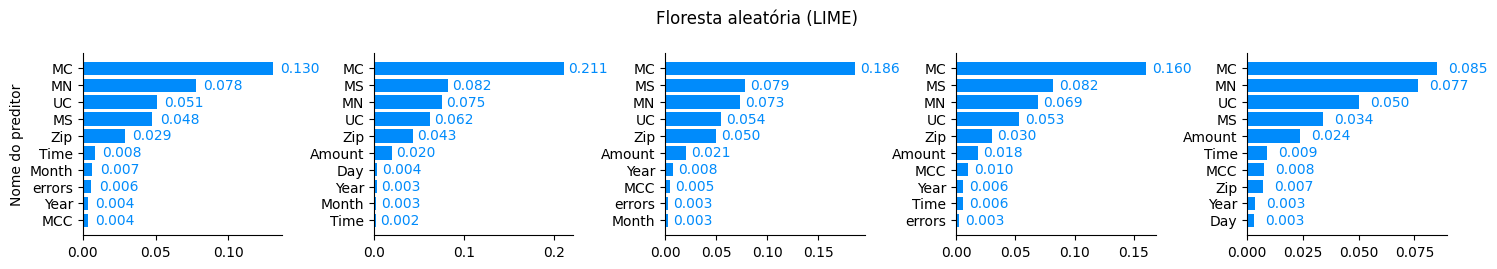

In [61]:
plot_lime_results_to_file(cross_random_fres, "Floresta aleatória (LIME)", "syntetic_img/random_forest_feature_importance_plot(lime).pdf")

X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names
X does not have valid feature names, but LinearSVC was fitted with feature names


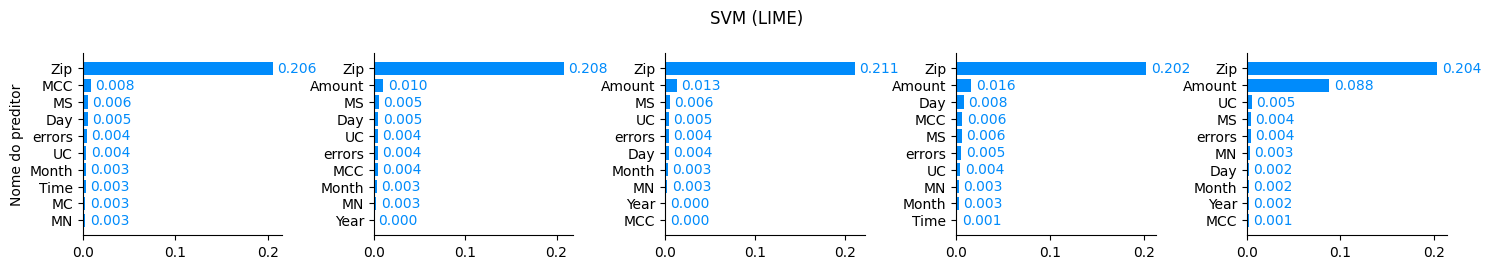

In [62]:
plot_lime_results_to_file_for_svm(cross_svm, "SVM (LIME)", "syntetic_img/svm_feature_importance_plot(lime).pdf")

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


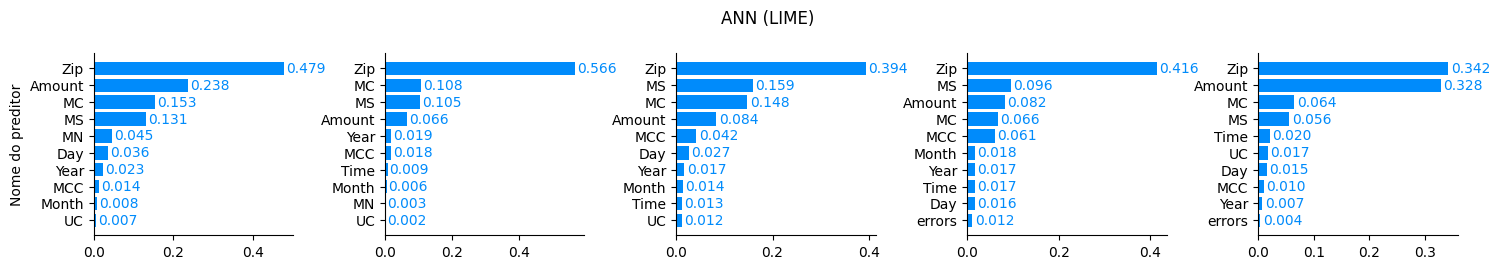

In [63]:
plot_lime_results_to_file(cross_ann, "ANN (LIME)", "syntetic_img/ann_feature_importance_plot(lime).pdf")

# Calculando número de acertos e erros

In [65]:
def compute_agreement(data_dict):
    logistic_regression_values = data_dict['logistic_regression_values']
    num_agreements = {}
    for key in ['logistic_regression_lime', 'logistic_regression_shap', 'random_forest_lime', 'random_forest_shap', 'svm_lime', 'svm_shap', 'mlp_classifier_lime', 'mlp_classifier_shap', 'decision_tree_lime', 'decision_tree_shap']:
        num_agreements[key] = [sum([1 for s in data_dict[key][i] if s in logistic_regression_values[i]]) for i in range(len(logistic_regression_values))]
    return num_agreements


In [66]:
res = compute_agreement(data_dict)
print(res)

{'logistic_regression_lime': [8, 8, 8, 8, 8], 'logistic_regression_shap': [8, 8, 8, 8, 9], 'random_forest_lime': [8, 9, 8, 8, 8], 'random_forest_shap': [8, 8, 8, 8, 8], 'svm_lime': [8, 8, 8, 8, 8], 'svm_shap': [8, 8, 8, 8, 8], 'mlp_classifier_lime': [8, 8, 8, 8, 8], 'mlp_classifier_shap': [8, 8, 8, 8, 8], 'decision_tree_lime': [8, 8, 8, 8, 8], 'decision_tree_shap': [9, 8, 8, 8, 8]}
